## Product Backorder Prediction

Material back-order is a well-known issue that concerns the availability of a product when it is needed for further production or when a customer wishes to purchase it. Here, the prediction will identify the likelihood of having backorders, which will be very useful because such a tendency may result in the loss of a customer because it will affect timely production or product shortage when a customer wants it.

##### Business Problem:
A manufacturing company that produces and sells products (identified by the SKU). The company has a large inventory, and they want to predict which products are likely to go on backorder in the near future so they can take preemptive measures to avoid stockouts.

##### Background:
In terms of cost, predicting and preventing backorders can have a significant impact on a company's financial performance. When a product goes on backorder, it can result in lost sales revenue, lower customer satisfaction, and potential damage to the company's reputation.

On the other hand, maintaining excessive inventory levels can also be costly. It ties up working capital, takes up valuable storage space, and increases the risk of products becoming obsolete or expiring.

Cost are as following: The company sells 1,000 units on average per month at a price of dollar 60 per unit (avg cost). The cost of of warehousing and maintaining these units is dollar 10 per unit per month (avg cost)

In [1]:
#pip install imbalanced-learn

#pip install tensorflow-gpu

### 1.0 Import and install python libraries and Set Random Seed
Here we import any Python libraries that we plan to use.

In [2]:
# import numpy and pandas libraries
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
import sys
from scikeras.wrappers import KerasClassifier
from keras.initializers import GlorotNormal
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score ,f1_score,classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
sys.setrecursionlimit(10000)
warnings.filterwarnings("ignore")

# set random seed to ensure that results are repeatable
np.random.seed(113)

### 2.0 Load data
Load data (it's already cleaned and preprocessed)

In [3]:
X_train = pd.read_csv("bop_X_train.csv")
X_test = pd.read_csv("bop_X_test.csv")
y_train = pd.read_csv("bop_y_train.csv")
y_test = pd.read_csv("bop_y_test.csv")

#### Performance Evaluation Parameter to be considered:
In the case of Backorders, it happens very rarely that the products goes to backorder. So in this type of problems , Accuracy is not a useful metric since it works well with Balanced dataset.
Since the dataset is imbalanced, the ideal performance metric would be Precision, Recall and F1 score , especially not to miss failure cases.

True Positive: The product was detected as being on backorder and it turned out to be True. Profit generated from such items is a benefit of correctly predicting backorders.

True Negative: The product was detected as not being on backorder, and it turned out to be true. We will not be generating extra and we will save on manufacturing and inventory. 

False Positive: Product detected as Backorder when it is not. This would cost the company because we predicted a few items as Backorder items but they were not on the list. The cost of warehousing for such items is the cost of false positives.
The cost of warehousing and maintaining these units is dollar 10 per unit per month, the total cost of false positives for 100 units would be dollar 1000 per month.

False Negative: The model fails to detect the product, and it remains as Non-Backorder. This will cost the company money due to the cost of incorrectly missing items when there was a demand for them.
The company sells at a price of dollar 60 per unit, and the model fails to predict that 100 units will go on backorder, the company may lose potential sales revenue of dollar 6,000 from these missed sales.

F1 Score might be a better measure to use if we need to seek balance between Precision and Recall and also given that there is uneven class distribution(large number of Actual Negatives).
F1 Score will be used when False Positives and False Negatives are more important as they are crucial for Business cost.

In [4]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

### 3.1 Logistic Regression
#### 3.1.1 Logistic Regression Random Search CV using default,L1,L2,Elastic,liblinear regularization
Conduct an initial random search across a wide range of possible parameters.

In [5]:
score_measure = "f1"
kfolds = 5

param_grid = {
    'max_iter':np.arange(500,1000),
    'penalty': ['None','l1','l2','elasticnet'],
    'solver':['saga','liblinear']
}

log_reg_model = LogisticRegression()
rand_search = RandomizedSearchCV(estimator = log_reg_model, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best f1 score is 0.7679671387159592
... with parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 949}


#### 3.1.2 Logistic Regression Grid Search CV using default,L1,L2,Elastic,liblinear regularization
Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [6]:
score_measure = "f1"
kfolds = 5
max_iter = rand_search.best_params_['max_iter']
penalty = rand_search.best_params_['penalty']
solver = rand_search.best_params_['solver']

param_grid = {
    'max_iter': np.arange(max_iter-5,max_iter+5),  
    'penalty': [penalty],
    'solver': [solver]
}

log_reg_model = LogisticRegression()
grid_search = GridSearchCV(estimator = log_reg_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallLogistic = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best f1 score is 0.7679671387159592
... with parameters: {'max_iter': 944, 'penalty': 'l1', 'solver': 'liblinear'}


In [7]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Logistic Regression", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 3.2 Support Vector Machine
#### 3.2.1 SVM Random Search CV using linear, rbf and poly kernal
Conduct an initial random search across a wide range of possible parameters.

In [8]:
score_measure = "f1"
kfolds = 5

param_grid = {
    'C': np.arange(1,25),   
    'gamma': ['scale','auto'],
    'kernel':['linear','rbf','poly']
}

svm_model = SVC()
rand_search = RandomizedSearchCV(estimator = svm_model, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
The best f1 score is 0.7649504435100682
... with parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 24}


#### 3.2.2 SVM Grid Search CV using linear, rbf and poly kernal
Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [9]:
score_measure = "f1"
kfolds = 5

C = rand_search.best_params_['C']
gamma = rand_search.best_params_['gamma']
kernel = rand_search.best_params_['kernel']

param_grid = {
    'C': np.arange(C-2,C+2),  
    'gamma': [gamma],
    'kernel': [kernel]
    
}

svm_model = SVC()
grid_search = GridSearchCV(estimator = svm_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallSVM = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The best f1 score is 0.7649504435100682
... with parameters: {'C': 24, 'gamma': 'scale', 'kernel': 'linear'}


In [10]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"SVM", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 3.3 Decision Tree Classifer
#### 3.3.1 DTree Random Search CV
Conduct an initial random search across a wide range of possible parameters.

In [11]:
score_measure = "f1"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(1,100),  
    'min_samples_leaf': np.arange(1,100),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,50), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best f1 score is 0.8858309279989246
... with parameters: {'min_samples_split': 4, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0006000000000000001, 'max_leaf_nodes': 99, 'max_depth': 46, 'criterion': 'entropy'}


#### 3.3.2 DTree Grid Search CV
Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [12]:
score_measure = "f1"
kfolds = 5
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']

param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallTree = grid_search.best_estimator_

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
The best f1 score is 0.8867222254214667
... with parameters: {'criterion': 'entropy', 'max_depth': 45, 'max_leaf_nodes': 99, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [13]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

#### 3.3.4 Diagrams of the Dtree:

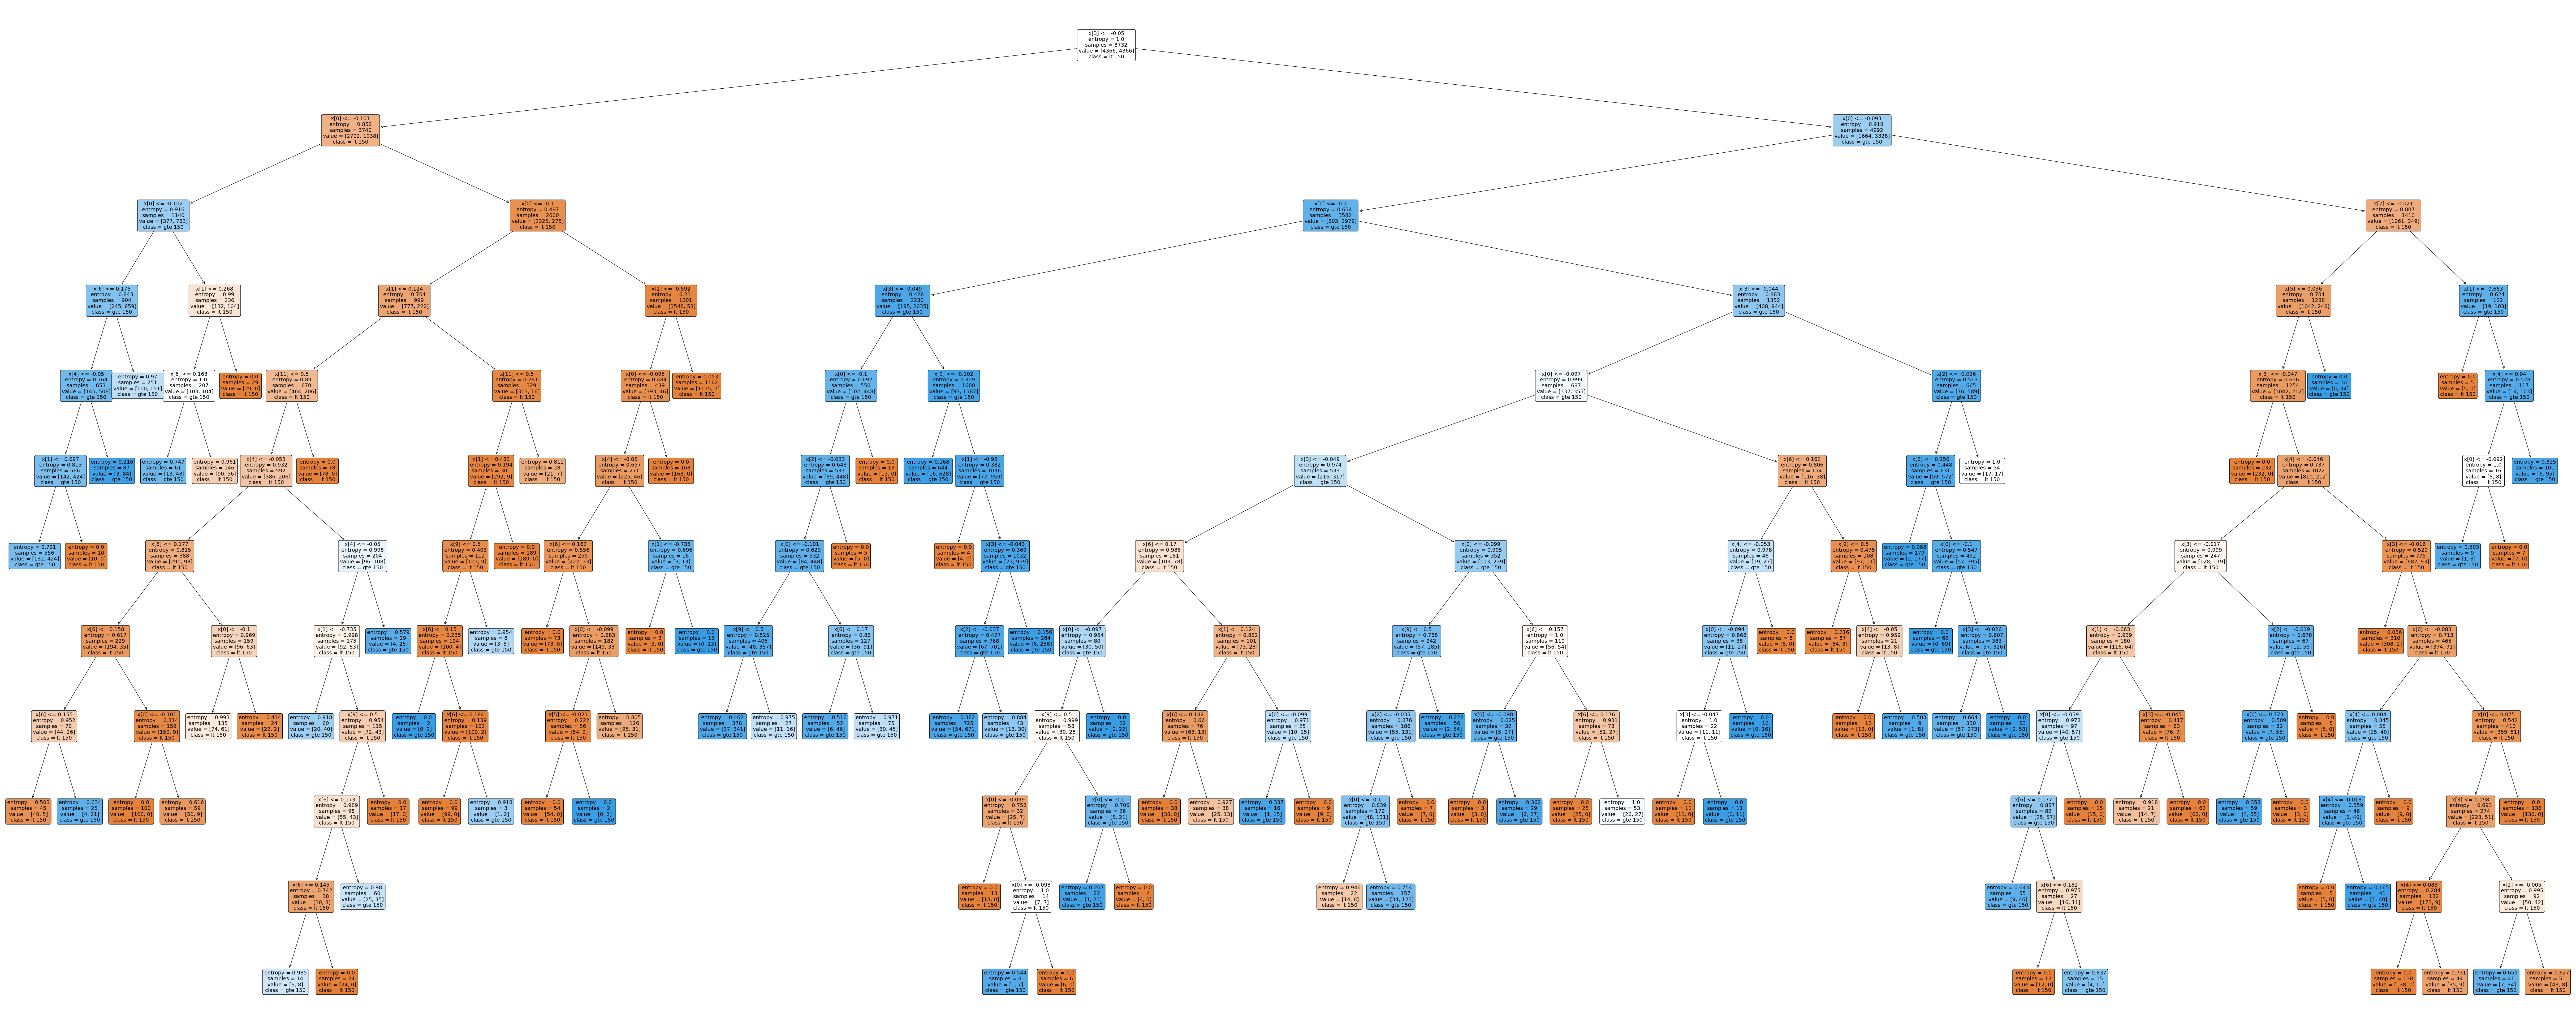

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(125,50))
tree = plot_tree(grid_search.best_estimator_,
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

### 3.4 Neural Net

#### 3.4.1 Neural Net Random Search CV
Conduct an initial random search across a wide range of possible parameters.

In [15]:
%%time

score_measure = "f1"
kfolds = 5

param_grid = {
    'hidden_layer_sizes': [ (50,), (70,),(50,30), (40,20),],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0, .2, .5, .7, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.5],
    'max_iter': [5000]
}

ann = MLPClassifier()
rand_search = RandomizedSearchCV(estimator = ann, param_distributions=param_grid, cv=kfolds, n_iter= 100,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

bestRecallTree = rand_search.best_estimator_

print(grid_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'criterion': 'entropy', 'max_depth': 45, 'max_leaf_nodes': 99, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 1, 'min_samples_split': 3}
CPU times: total: 1min 56s
Wall time: 8min 24s


#### 3.4.2  Neural Net Grid Search CV
Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [16]:
score_measure = "f1"
kfolds = 5

hidden_layer_sizes = rand_search.best_params_['hidden_layer_sizes']
activation = rand_search.best_params_['activation']
solver = rand_search.best_params_['solver']
alpha = rand_search.best_params_['alpha']
learning_rate = rand_search.best_params_['learning_rate']
learning_rate_init = rand_search.best_params_['learning_rate_init']
max_iter = rand_search.best_params_['max_iter']

param_grid = {
    'hidden_layer_sizes': [hidden_layer_sizes],  
     'activation' : [activation] ,
    'solver' : [solver],
    'alpha' : np.arange(alpha+0.001),
    'learning_rate' : [learning_rate],
    'learning_rate_init' :  np.arange(learning_rate_init-0.0001,learning_rate_init+0.0001),
    'max_iter' : np.arange(max_iter-2,max_iter+2)  
}

ann = MLPClassifier()
grid_search = GridSearchCV(estimator = ann, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

bestRecallTree = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'activation': 'relu', 'alpha': 0.0, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.0009, 'max_iter': 5001, 'solver': 'adam'}


In [17]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Neural Net", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### 3.5 Keras Model
#### 3.5.1 Keras Model Random Search CV
Conduct an initial random search across a wide range of possible parameters.

In [18]:
# Define f1 metric function
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1_score

# Define the model
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=14))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile model
# Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f1])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

def build_clf(hidden_layer_sizes, dropout):
    ann = tf.keras.models.Sequential()
    ann.add(keras.layers.Input(shape=14)),
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    ann.compile(loss = 'binary_crossentropy', metrics = [f1])
    return ann

Epoch 1/20
88/88 [==============================] - 1s 10ms/step - loss: 0.6392 - f1: 0.6191 - val_loss: 0.5245 - val_f1: 0.4641
Epoch 2/20
88/88 [==============================] - 1s 6ms/step - loss: 0.5719 - f1: 0.6833 - val_loss: 0.4623 - val_f1: 0.3659
Epoch 3/20
88/88 [==============================] - 1s 7ms/step - loss: 0.5709 - f1: 0.6797 - val_loss: 0.7035 - val_f1: 0.4769
Epoch 4/20
88/88 [==============================] - 1s 7ms/step - loss: 0.5436 - f1: 0.7131 - val_loss: 0.5277 - val_f1: 0.5562
Epoch 5/20
88/88 [==============================] - 1s 7ms/step - loss: 0.5169 - f1: 0.7328 - val_loss: 0.4720 - val_f1: 0.5404
Epoch 6/20
88/88 [==============================] - 1s 7ms/step - loss: 0.5166 - f1: 0.7184 - val_loss: 0.5815 - val_f1: 0.5368
Epoch 7/20
88/88 [==============================] - 1s 7ms/step - loss: 0.5184 - f1: 0.7213 - val_loss: 0.4727 - val_f1: 0.5369
Epoch 8/20
88/88 [==============================] - 1s 7ms/step - loss: 0.5111 - f1: 0.7297 - val_loss:

In [19]:

score_measure = f1
kfolds = 5

param_grid = {
    'optimizer__learning_rate': [0.0005, 0.001, 0.005],
    'model__hidden_layer_sizes': [(70,),(90, ), (100, 90)],
    'model__dropout': [0, 0.1],
    'batch_size':[20, 60, 100],
    'epochs':[10, 25],
    'optimizer':["adam",'sgd']
}

keras_clf = KerasClassifier(model=build_clf, hidden_layer_sizes=14, dropout = 0.0)
keras_clf.get_params().keys()

rand_search = RandomizedSearchCV(estimator=keras_clf, param_distributions=param_grid, scoring=score_measure, 
                                 n_iter=10, cv=kfolds)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
callback = [earlystop]

_ = rand_search.fit(X_train, y_train, callbacks=callback, verbose=0)

print(f"The best F1 score is with parameters: {rand_search.best_params_}")

The best F1 score is with parameters: {'optimizer__learning_rate': 0.0005, 'optimizer': 'sgd', 'model__hidden_layer_sizes': (90,), 'model__dropout': 0, 'epochs': 10, 'batch_size': 100}


In [20]:
c_matrix = confusion_matrix(y_test, rand_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Keras Sequential", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

25/25 [==============================] - 0s 2ms/step


###  4.0 Summary of the models
Sorted by F1, the best models are:

In [21]:
performance.sort_values(by=['F1'])

,model,Accuracy,Precision,Recall,F1
0,Keras Sequential,0.593763,0.325190,0.656463,0.434930
0,SVM,0.594978,0.359864,0.899660,0.514091
0,Logistic Regression,0.644795,0.389272,0.863946,0.536714
0,Neural Net,0.772377,0.513211,0.858844,0.642494
0,Decision Tree,0.837181,0.609412,0.880952,0.720445


F1 value has been taken here in consideration to give FN and FP have been given equal weightage.

As per the above matrix, the best performance is of the Decision Tree with 72.02% F1 score. The Logistic Regression and SVM has F1 value of 51.40% and 53.67% respectively. 

##### Assignment 2

As per the above matrix, the Neural Net has a F1 of 64.24%. As compared to the other models it performed better than Logistic Regression and SVM with a F1 score of 51.40% and 53.67% respectively, but not better than Decision Tree with 72.04% F1 score. 

As per the above matrix, the Keras Model  has a F1 of 43.49%. As compared to the other models it did not perform better than Logistic Regression with 51.40%, SVM with a F1 score of and 53.67% and Decision Tree with 72.02% F1 score.

Based on the F1 parameters the Decision Tree is the best predictive model. 

### 5.0 Business Evaluation

Let us compare the phenomenon the cost that would cost a company for taking a modelling approcah and a without modelling approach. We will compare this on the basis of Decision tree F1 scores.

For every false positive prediction (product detected as backorder but it is not), the company incurs a cost of dollar 10 for excess inventory and warehousing.

For every false negative prediction (product not detected as backorder but it is), the company incurs a cost of dollar 60 in lost sales revenue per unit.

##### Without Modelling Approach:
Without a modeling approach, the company experiences 200 false positives and 50 false negatives for every 1000 predictions made.
Using the cost estimates, the cost of false positives would be 200 x 10 dollars = 2000 dollars while the cost of false negatives would be 25 x 60 = 1500 dollars. This would result in a total cost of 3500 dollars for every 1000 predictions made.



##### With Modelling Approach:
If the company used a modeling approach with an F1 score of 0.72 the cost of false positives would be 56 x dollars 10 = 560 dollars, and the cost of false negatives would be reduced to 7 x 60 = 420 dollars. This would result in a total cost of dollar 980 for every 1000 predictions made.

##### Should we use the model?
By using a modeling approach with an optimized F1 score, the company could potentially save dollar 2520 for every 1000 predictions made, compared to relying on manual methods without a modeling approach.

As backorders can upset consumers, lead to canceled orders and decreased customer loyalty, the manufacturing company can use the modelling technique not only to avoid backorders, but also avoid overstocking every product (leading to higher inventory costs).
